In [30]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import zuko
import lampe.inference, lampe.utils
from itertools import islice
import flowjax
from flowjax.flows import BlockNeuralAutoregressiveFlow, CouplingFlow
from flowjax.train_utils import train_flow
import jax.random as random
import flowjax.distributions, flowjax.flows
import jax
from numpyro.distributions import (
    Distribution,
    Normal,
    Bernoulli,
    Cauchy,
    constraints,
)
from flowjax.distributions import Distribution as FlowJaxDist
import matplotlib.pyplot as plt

In [31]:
N = 50000
prior_over_mu = zuko.distributions.Normal(torch.Tensor([0.0]), torch.Tensor([25.0]))

Utils

In [32]:
def true_data_generating_process():
    """Computes x = (mean,var) of a sample of size 100 drawn from N(mu, 2) and mu drawn from a prior

    Returns:
        tuple: x, mu
    """
    mu = torch.distributions.Normal(torch.Tensor([0]), torch.Tensor([1])).sample((1, )).detach().item()
    dist = torch.distributions.Normal(mu, 2.0)
    sample = dist.sample((100, ))
    mean, var = torch.mean(sample).item(), torch.var(sample).item()
    x = mean, var
    return x, mu

Simulation (line 1 & 2 of Algorithm 1)

In [33]:

def simulator(thetas: torch.Tensor):
    """Simulator, maps theta -> x = (mean, var)

    Args:
        thetas (torch.Tensor): Parameters

    Returns:
        torch.Tensor: Tensor of size (theta.size, 2) of (mean, var)
    """
    N = thetas.size()[0]
    x = torch.empty((N, 2))
    for i, theta in enumerate(thetas):
        dist = torch.distributions.Normal(theta, 1.0)
        samples = dist.sample((100,))
        means, var = torch.mean(samples), torch.var(samples)
        x[i][0], x[i][1] = means, var
    return x

def scale(quantity):
    '''
    Standardizes the quantity
    '''
    means, std = quantity.mean(axis=0), quantity.std(axis=0)
    quantity = quantity - means
    quantity = quantity/std
    return quantity

#Raw simulations
theta_raw = prior_over_mu.sample((N, ))
x_raw = simulator(theta_raw)
#Standardized versions
theta = scale(theta_raw)
x = scale(x_raw)
dataset = lampe.data.JointDataset(theta, x)


#True observations 
y_raw = torch.tensor([true_data_generating_process()[0] for i in range(x.shape[1])])
y = scale(y_raw)

theta_test = scale(prior_over_mu.sample((N//10, )))
x_test = scale(simulator(theta_test))
dataset_test = lampe.data.JointDataset(theta_test, x_test)

'''Creates a 'true' dataset (theta*, x*) ~ p(theta, x)'''
y_star_list = []
theta_star_list = []
for i in range(10000):
    y_star, theta_star = true_data_generating_process()
    y_star_list.append(y_star)
    theta_star_list.append(theta_star)
y_star_raw = torch.tensor(y_star_list)
theta_star_raw = torch.tensor(theta_star_list)
theta_star = scale(theta_star_raw)
y_star = scale(y_star_raw)
dataset_star = lampe.data.JointDataset(theta_star.unsqueeze(1), y_star)

Train NPE q(theta|x) on the simulated dataset {(thetai, xi)}, i=1, ... N
Uses a neural spline flow defining the transform on the interval [-5, 5] using 10  spline segments and 5 coupling layers. The base of the flow is a standard Gaussian distribution. 

In [34]:
def build_nsf(features, context):
    """Callable to isntanciate the NPE with NSFs"""
    return zuko.flows.NSF(features, context, bins=10, transforms=5)
q_NPE = lampe.inference.NPE(theta_dim = 1, x_dim=2, build=build_nsf)

In [35]:
#Param for training
max_epochs = 50
learning_rate_NSF = 5*10e-4
batch_size = 256
#Optim
optimizer = torch.optim.Adam(q_NPE.parameters(), learning_rate_NSF)
step = lampe.utils.GDStep(optimizer)
#Creates the loader
loader = lampe.data.DataLoader(dataset, batch_size, shuffle=True)
loss = lampe.inference.NPELoss(q_NPE)
#For early stopping 
with torch.no_grad():
    min_loss = loss(theta_test, x_test)
time_to_min=1
min_loss_list = [min_loss]
patience = 5 

q_NPE.train()

for epoch in range(max_epochs):
    loss_epoch = 0
    for theta, x_batch in loader:
        losses = loss(theta, x_batch)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        loss_epoch += losses
    print(f" Epoch {epoch} ")
    
    with torch.no_grad():
        loss_test = loss(theta_test, x_test)
        min_loss_list.append(loss_test)
        
        if len(min_loss_list) - np.argmin(min_loss_list) > patience:
            print(f"Early stop at epoch {epoch}")
            break
q_NPE.eval()
    

 Epoch 0 
 Epoch 1 
 Epoch 2 
 Epoch 3 
 Epoch 4 
 Epoch 5 
Early stop at epoch 5


NPE(
  (flow): NSF(
    (transforms): ModuleList(
      (0-4): 5 x MaskedAutoregressiveTransform(
        (base): MonotonicRQSTransform(bins=10)
        (order): [0]
        (hyper): MaskedMLP(
          (0): MaskedLinear(in_features=3, out_features=64, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=64, out_features=29, bias=True)
        )
      )
    )
    (base): DiagNormal(loc: tensor([0.]), scale: tensor([1.]))
  )
)

In [36]:
#TODO Faire des sampling ici pour " iii) NPE in which we assume no model errors"

Train q(x) on {xi} i=1, ... N (so first gen the x)
For q(x) uses of a block neural autoregressive flow, single hidden layer of size 8D, x in R^d

NAF dans zuko? (mais pas "block" ... )

In [37]:
key, subkey = random.split(random.PRNGKey(42))
key, flow_key, train_key = random.split(key, 3)

In [38]:
#Preparaing dataset & loader
dataset = jax.numpy.array(x.detach().numpy())
batch_size = 256
base_dist_q_x = flowjax.distributions.Normal(x.shape[1])
q_x = flowjax.flows.BlockNeuralAutoregressiveFlow(key, base_dist_q_x)

#Training param
max_epochs = 50
learning_rate_BNAF = 10e-2
epsilon = 1e-5

q_x, x_losses = train_flow(
        train_key,
        q_x,
        dataset,
        learning_rate=learning_rate_BNAF,
        batch_size=batch_size,
        max_epochs=max_epochs,
        show_progress=True,
    )



 14%|█▍        | 7/50 [00:08<00:52,  1.22s/it, train=2.85, val=2.84]

Max patience reached.


Sample x~m from p(x | y0) % p(y0 \ x) q(x), m = 1, ... M using MCMC

Spike and slab

In [39]:
M = 100000
warm_up_steps = 20000
traj_length = 1
target_acceptance_prob = 0.95

In [40]:

class FlowDist(Distribution):
    "Wraps flow as numpyro compatible distribution for MCMC."
    support = constraints.real

    def __init__(self, flow: FlowJaxDist):
        self.flow = flow
        super().__init__(batch_shape=(), event_shape=(flow.dim,))

    def sample(self, key, sample_shape=()):
        raise NotImplementedError()

    def log_prob(self, value):
        batch_size = value.shape[:-1]
        value = value.reshape(-1, self.flow.dim)
        return self.flow.log_prob(value).reshape(batch_size)


In [41]:
from numpyro import sample
import numpyro
def spike_and_slab_denoiser(
    y_obs: jax.numpy.ndarray,
    flow,
    spike_std: float = 0.01,
    slab_scale: float = 0.25,
    misspecified_prob: float = 0.5,
):
    """Model that uses Bernoulli random variable to index between using
    a tight normal (for approximately well specified), and a Cauchy (for
    misspecified) dimensions.

    Args:
        y_obs (jnp.ndarray): Observed data.
        flow (FlowJaxDist): Flow from flowjax package.
        misspecified_prob (float, optional): Prior probability of being in slab. Defaults to 0.5.
    """
    with numpyro.plate("d", len(y_obs)):
        misspecified = sample("misspecified", Bernoulli(probs=misspecified_prob))

    x = sample("x", FlowDist(flow))

    with numpyro.handlers.mask(mask=~misspecified.astype(bool)):
        sample("y_obs_w", Normal(x, spike_std), obs=y_obs)

    with numpyro.handlers.mask(mask=misspecified.astype(bool)):
        sample("y_obs_m", Cauchy(x, slab_scale), obs=y_obs)


In [42]:
x_jax = jax.numpy.array(x.detach().numpy())
y_jax = jax.numpy.array(y.detach().numpy())
from numpyro.infer import MCMC, HMC, MixedHMC, init_to_value
init = init_to_value(
        values={"x": x_jax[0], "misspecified": jax.numpy.ones(len(y_jax), int)}
    )
denoiser = spike_and_slab_denoiser
kernel = MixedHMC(
        HMC(denoiser, trajectory_length=1, init_strategy=init, target_accept_prob=0.95,)
    )
mcmc = MCMC(
        kernel,
        num_warmup=warm_up_steps,
        num_samples=M,
        progress_bar=True,
    )
model_kwargs = {"y_obs": y_jax, "flow":q_x}
key, mcmc_key = random.split(key)
mcmc.run(mcmc_key, **model_kwargs)

sample: 100%|██████████| 120000/120000 [02:41<00:00, 741.93it/s, 5 steps of size 3.04e-01. acc. prob=0.95]


Sample theta ~q(theta | xm), m = 1, ..., M

In [43]:
xm = mcmc.get_samples()["x"]
xm_tensor = torch.Tensor(np.array(xm))
thetas_m = q_NPE.flow(xm_tensor).sample()

In [44]:
k = M//10
perm = torch.randperm(xm_tensor.size()[0])
idx = perm[:k]
xm_sample = xm_tensor[idx]

In [45]:
with torch.no_grad():
    thetasm = q_NPE.sample(xm_sample)

100%|██████████| 10000/10000 [04:02<00:00, 41.24pair/s]


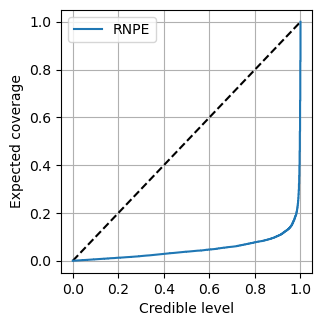

In [46]:
from lampe.diagnostics import expected_coverage_mc, expected_coverage_ni
npe_levels, npe_coverages = expected_coverage_mc(q_NPE.flow, dataset_star)
from lampe.plots import nice_rc, coverage_plot
fig = coverage_plot(npe_levels, npe_coverages, legend='RNPE')

In [47]:
def q_NPE_log_prob(flow, thetas, xm):
    res = []
    for i, theta in enumerate(thetas.unsqueeze_(1)):
        xi = xm[i]
        log_prob = flow.flow(xi).log_prob(theta) 
        res.append(log_prob.detach().item())
    return res

In [48]:
q_NPE.requires_grad_=False

In [49]:
log_probs = q_NPE_log_prob(q_NPE, theta_star, y_star)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fde504e2f10>,
 'caps': [<matplotlib.lines.Line2D at 0x7fde50184430>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fde504e2df0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fde50184d30>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fde5017aa00>],
 'means': []}

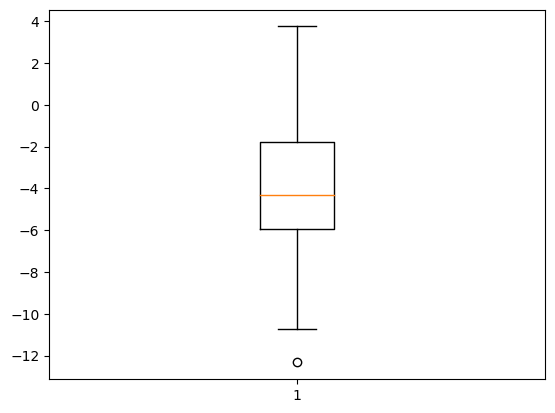

In [50]:
plt.boxplot(log_probs)

Il faut aussi faire les 2 autres simu cad NPE (comme avant) et en mettant directement le modele d'erreur dans le simu

In [56]:
def noisy_simulator():
    #Sample the parameters theta [mu]
    sigma = 0.01
    tau = 0.25
    rho = 1/2
    x_noisy_raw, theta_noisy_raw = x_raw, theta_raw
    x_noisy_test, theta_noisy_test = x_test, theta_test

    for i, x in enumerate(x_noisy_raw):
        spike_dist = torch.distributions.Normal(x, torch.Tensor([sigma]))
        slab_dist = torch.distributions.Cauchy(x, torch.Tensor([tau]))
        spike = ((1 - rho) *spike_dist.sample((1, )))[0]
        slab = (rho * slab_dist.sample((1, )))[0]
        x_noisy_raw[i] += spike + slab
    for i, x in enumerate(x_noisy_test):
        spike_dist = torch.distributions.Normal(x, torch.Tensor([sigma]))
        slab_dist = torch.distributions.Cauchy(x, torch.Tensor([tau]))
        spike = ((1 - rho) *spike_dist.sample((1, )))[0]
        slab = (rho * slab_dist.sample((1, )))[0]
        x_noisy_test += spike + slab
    x_noisy = scale(x_noisy_test)
    theta_noisy = scale(theta_noisy_raw)
    return x_noisy, theta_noisy, x_noisy_test, theta_noisy_test
        

In [57]:
X_noisy, thetas, X_noisy_test, thetas_test = noisy_simulator()

In [ ]:
q_NPE_noisy = zuko.flows.NSF(features=1, context=2, bins=10, transforms=5) #TODO! Continuer ICI